In [1]:
import pandas as pd 
import numpy as np
import os 
import math
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential 
from keras.layers import Dense, BatchNormalization, Dropout, Activation
from keras.layers import LSTM, GRU 
from keras.optimizers import Adam, SGD, RMSprop

%matplotlib inline

/home/parab/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
nifty = pd.read_csv('Data/nifty50.csv')

In [3]:
nifty.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0.0
1,2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0.0
2,2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0.0
3,2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0.0
4,2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0


In [4]:
nifty.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2722.000000,2722.000000,2722.000000,2722.000000,2722.000000,2722.000000
mean,6701.607531,6743.648368,6650.014105,6697.464089,6697.464089,96687.215283
std,2102.754767,2096.967411,2103.448414,2099.568239,2099.568239,104641.370036
min,2553.600098,2585.300049,2252.750000,2524.199951,2524.199951,0.000000
25%,5194.699951,5229.924926,5123.837525,5192.400024,5192.400024,0.000000
50%,5988.250000,6018.324951,5939.975098,5982.824951,5982.824951,108250.000000
75%,8325.124756,8356.400391,8269.900391,8323.800049,8323.800049,175200.000000
max,11751.799805,11760.200195,11710.500000,11738.500000,11738.500000,719000.000000


In [5]:
nifty.isnull().sum()

Date          0
Open         25
High         25
Low          25
Close        25
Adj Close    25
Volume       25
dtype: int64

In [6]:
nifty.fillna(method = 'ffill', inplace = True)

In [7]:
nifty.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
nifty.shape

(2747, 7)

In [9]:
nifty.Date.unique()

array(['2007-09-17', '2007-09-18', '2007-09-19', ..., '2018-10-29',
       '2018-10-30', '2018-10-31'], dtype=object)

In [10]:
# Features
nifty.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

## Plotting Data 

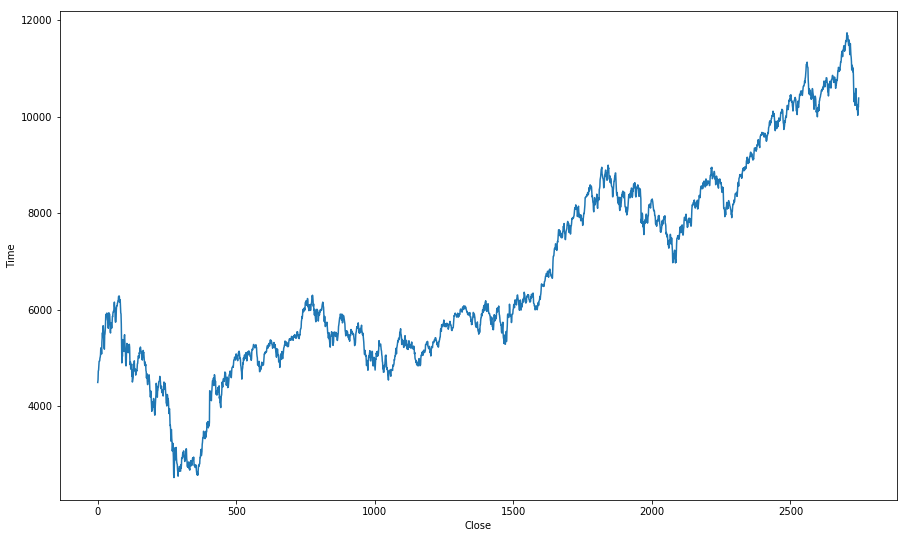

In [11]:
fig = plt.figure(figsize = (15, 9))
nifty['Close'].plot()
plt.xlabel('Close')
plt.ylabel('Time')
plt.show()

In [12]:
# Taking close price for forcasting future prices.

In [13]:
data = nifty['Close'].values
print(data)
data = data.reshape(len(data), 1)

[ 4494.649902  4546.200195  4732.350098 ... 10250.849609 10198.400391
 10386.599609]


In [14]:
# Feature scaling
scaler = MinMaxScaler(feature_range = (0, 1))
data = scaler.fit_transform(data)

In [15]:
train = int(len(data) * 0.80)
test = len(data) - train 

In [16]:
print(train, test)

2197 550


In [17]:
train = data[0:train]
print(train)

[[0.21384695]
 [0.21944155]
 [0.23964383]
 ...
 [0.66841219]
 [0.67147256]
 [0.66788036]]


In [18]:
train.shape

(2197, 1)

In [19]:
test = data[len(train):]

In [20]:
print(train.shape, test.shape)

(2197, 1) (550, 1)


In [21]:
def preprocess(data, n_features):
    x, Y = [], []
    for i in range(len(data) - n_features - 1):
        m = data[i : (i + n_features), 0]
        x.append(m)
        Y.append(data[i + n_features, 0])
    return np.array(x), np.array(Y)

In [22]:
n_features = 2 

train_X, train_Y = preprocess(train, n_features)
test_X, test_Y = preprocess(test, n_features)

In [23]:
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(2194, 2) (2194,) (547, 2) (547,)


In [24]:
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

In [25]:
filepath = 'Model/nifty_close_weight.hdf5'
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, epsilon = 0.0001, patience = 1, verbose = 1)
checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 1, save_best_only =  True, mode = 'max')

In [26]:
model = Sequential()
model.add(GRU(256, input_shape = (1, n_features), return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(256))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [27]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 256)            198912    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 740,737
Trainable params: 740,737
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = 0.0005), metrics = ['mean_squared_error'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [29]:
history = model.fit(train_X, train_Y, epochs = 10, batch_size = 128, callbacks = [checkpoint, lr_reduce], validation_data = (test_X, test_Y))

Train on 2194 samples, validate on 547 samples
Epoch 1/10
2194/2194 [==============================] - 3s 1ms/step - loss: 0.0888 - mean_squared_error: 0.0888 - val_loss: 0.0702 - val_mean_squared_error: 0.0702
Epoch 2/10
2194/2194 [==============================] - 1s 451us/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0282 - val_mean_squared_error: 0.0282
Epoch 3/10
2194/2194 [==============================] - 1s 410us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 4/10
2194/2194 [==============================] - 1s 417us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 5/10
2194/2194 [==============================] - 1s 410us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 6/10
2194/2194 [==============================] - 1s 426us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss:

In [30]:
train_score = model.evaluate(train_X, train_Y, verbose = 0)
print('Train score : %.5f MSE  (%.2f RMSE) '%(train_score[0], math.sqrt(train_score[0])))

Train score : 0.00011 MSE  (0.01 RMSE) 


In [31]:
test_score = model.evaluate(test_X, test_Y, verbose = 0)
print('Test score : %.5f MSE (%.2f RMSE)' % (test_score[0], math.sqrt(test_score[0])))

Test score : 0.00024 MSE (0.02 RMSE)


In [32]:
#model.save_weights('model.hdf5')

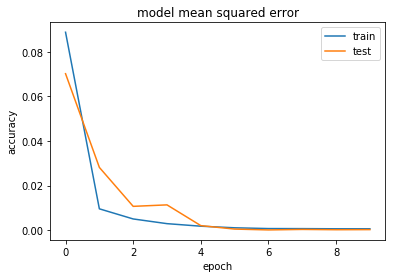

In [33]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')

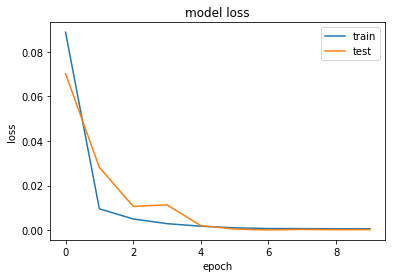

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [35]:
# Inverse transforming the scaled data 

In [36]:
pred = model.predict(test_X)
pred = scaler.inverse_transform(pred)
pred[:10]

array([[8598.812],
       [8607.486],
       [8634.248],
       [8650.382],
       [8666.994],
       [8688.981],
       [8665.639],
       [8648.021],
       [8659.203],
       [8637.453]], dtype=float32)

In [37]:
testY = test_Y.reshape(test_Y.shape[0], 1)
testY = scaler.inverse_transform(testY)
test[:10]

array([[0.65670749],
       [0.65853623],
       [0.65853623],
       [0.66400593],
       [0.66199818],
       [0.66733773],
       [0.66664862],
       [0.66255173],
       [0.66292606],
       [0.66484701]])

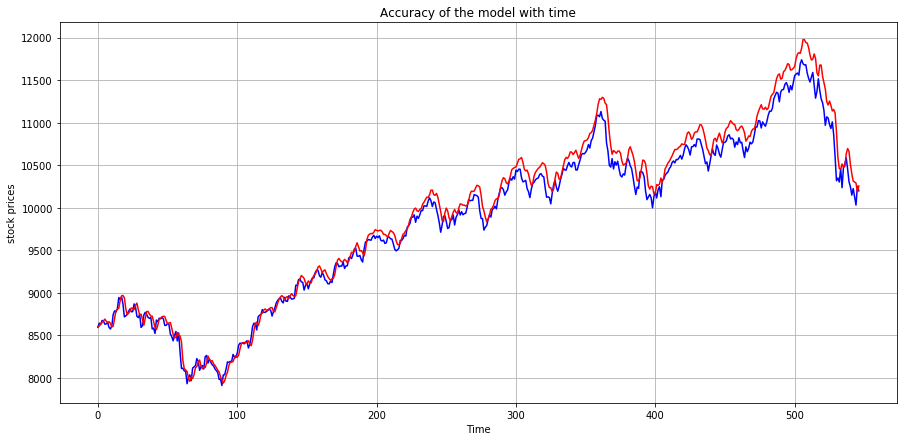

In [38]:
plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(testY, 'b')
plt.plot(pred, 'r')
plt.xlabel('Time')
plt.ylabel('stock prices')
plt.title('Accuracy of the model with time')
plt.grid(True)
plt.savefig('Plots/Predicted_Vs_Actual_StockPrices.png')
plt.show()